In [83]:
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("data/BTC_feature_data.csv", index_col="Unnamed: 0", parse_dates=True)

In [85]:
df.dropna(inplace=True)

The split of the dataset will be made based on the assumption that each row is independent given that we are controling the time and not using it for our predictions

In [87]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.phigh_day_touch.values
y_val = df_val.phigh_day_touch.values

In [88]:
df_train.head()

,phigh_day_touch,plow_day_touch,phigh_night_touch,plow_night_touch,ret_distance_phigh_day_open,ret_distance_plow_day_open,ret_distance_phigh_night_open,ret_distance_plow_night_open
2020-04-16,0,0,1,0,0.034060,0.082919,-0.019961,0.070223
2020-03-04,1,1,1,0,-0.008515,0.005208,-0.015047,0.006368
2022-07-31,0,1,1,1,-0.033535,0.011320,-0.004966,0.008918
2017-11-26,0,0,1,0,0.052343,0.080750,0.000000,0.070110
2020-06-08,1,0,1,1,-0.008876,0.027173,-0.008673,0.008512


Since we treat every row as an independent event we reset the index

In [89]:
df_train.reset_index(inplace=True, drop=True)

In [48]:
df_train.head(2)

,phigh_day_touch,plow_day_touch,phigh_night_touch,plow_night_touch,ret_distance_phigh_day_open,ret_distance_plow_day_open,ret_distance_phigh_night_open,ret_distance_plow_night_open
0,0,0,1,0,0.034060,0.082919,-0.019961,0.070223
1,1,1,1,0,-0.008515,0.005208,-0.015047,0.006368


In [49]:
for col in df_train.columns:
	print(col)
	print(df_train[col].unique()[:5])
	print(df_train[col].nunique())
	print()

phigh_day_touch
[0 1]
2

plow_day_touch
[0 1]
2

phigh_night_touch
[1 0]
2

plow_night_touch
[0 1]
2

ret_distance_phigh_day_open
[ 0.03406019 -0.00851536 -0.03353472  0.05234286 -0.00887574]
1004

ret_distance_plow_day_open
[0.08291862 0.00520761 0.01132019 0.08074991 0.02717276]
1004

ret_distance_phigh_night_open
[-0.01996144 -0.01504698 -0.0049659   0.         -0.00867347]
1003

ret_distance_plow_night_open
[0.07022307 0.00636836 0.00891791 0.07011036 0.00851241]
1004



## EDA
- Ranges of values
- Missing values
- Analysis of the target variable
- Feature importance analysis

In [90]:
categorical = ["phigh_day_touch", "plow_day_touch","phigh_night_touch", "plow_night_touch"]

numerical = ["ret_distance_phigh_day_open", "ret_distance_plow_day_open", 
            "ret_distance_phigh_night_open", "ret_distance_plow_night_open"]

### Ranges of values

In [91]:
df_train[numerical].describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
ret_distance_phigh_day_open,1004.0,-0.0140,0.0364,-0.2370,-0.0288,-0.0102,0.0040,0.1430
ret_distance_plow_day_open,1004.0,0.0199,0.0392,-0.1978,0.0002,0.0150,0.0377,0.2030
ret_distance_phigh_night_open,1004.0,-0.0215,0.0238,-0.2330,-0.0273,-0.0136,-0.0067,0.0000
ret_distance_plow_night_open,1004.0,0.0263,0.0254,0.0002,0.0099,0.0185,0.0347,0.2192


<AxesSubplot:>

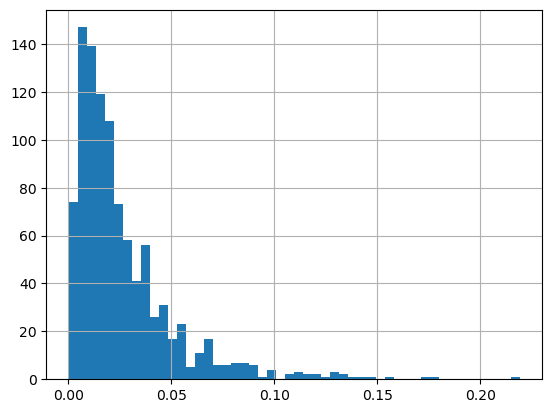

In [52]:
df_train['ret_distance_plow_night_open'].hist(bins=50)

The exploratory data analysis of the numerical features shows that the percentage distance between the high of the previous trading session and the open of the next session has a mean negative return of -0.0148 with standard deviation of 0.00367, the range of values is between -0.2370 and 0.143.

The results for the distance between the low of the previous day session and the open of the day shows a mean of 0.0196 wit standard deviation of 0.0396. The range of values are between -0.1978 and 0.2363.

Night session has interesting properties, the open of the day cannot be higher than the previous night high, and the open cannot be lower than the previous night low. By definition those distance has a left for the distance with previous night high and right skewed distribution for the distance between previous night low. 

### Missing values

In [53]:
df_train.isnull().sum()

phigh_day_touch                  0
plow_day_touch                   0
phigh_night_touch                0
plow_night_touch                 0
ret_distance_phigh_day_open      0
ret_distance_plow_day_open       0
ret_distance_phigh_night_open    0
ret_distance_plow_night_open     0
dtype: int64

There are no missing values in our dataset

### Target variable

Since we want to create four models to have four different targets we need to evaluate four different outcomes

In [54]:
for cat in categorical:
    print(df_train[cat].value_counts(normalize=True))

0    0.664343
1    0.335657
Name: phigh_day_touch, dtype: float64
0    0.72012
1    0.27988
Name: plow_day_touch, dtype: float64
0    0.601594
1    0.398406
Name: phigh_night_touch, dtype: float64
0    0.696215
1    0.303785
Name: plow_night_touch, dtype: float64


The first target feature is a binary outcome that evaluate if the price reach the previous day high, in the results 68% of the time we do reach the previous high, previous low is reach 70% of the time, and previous night high is reach 63% of the time and previous night low is reach 70% of the time.

### Feature importance

In [55]:
df_train[numerical].corrwith(df_train.phigh_day_touch).to_frame('correlation')

,correlation
ret_distance_phigh_day_open,0.193814
ret_distance_plow_day_open,0.171325
ret_distance_phigh_night_open,0.232611
ret_distance_plow_night_open,-0.061030


The independent features doesn't show strong correlation between each other which match the assumption of no multicolinearity for linear models.

In [56]:
df_train.groupby(by='phigh_day_touch')[numerical].mean()

,ret_distance_phigh_day_open,ret_distance_plow_day_open,ret_distance_phigh_night_open,ret_distance_plow_night_open
phigh_day_touch,,,,
0,-0.019051,0.015108,-0.025414,0.027421
1,-0.004117,0.029332,-0.013710,0.024134


<AxesSubplot:>

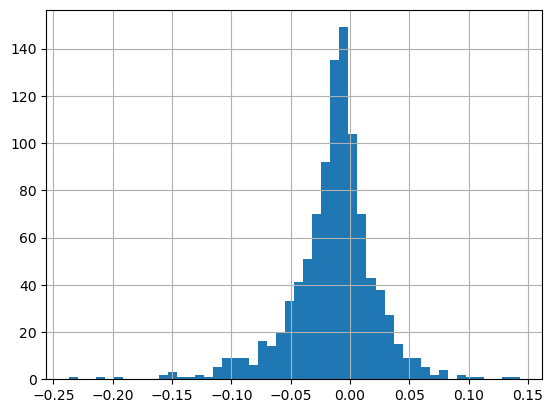

In [57]:
df_train["ret_distance_phigh_day_open"].hist(bins=50)

<AxesSubplot:>

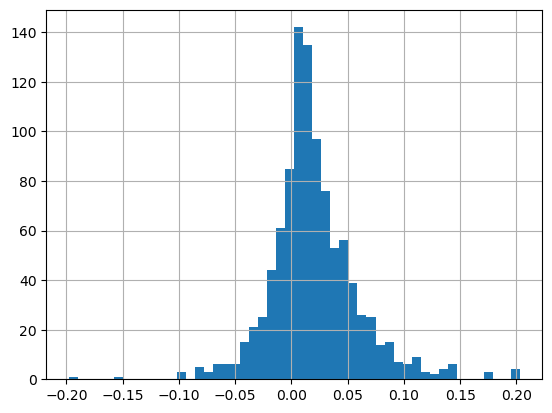

In [58]:
df_train["ret_distance_plow_day_open"].hist(bins=50)

<AxesSubplot:>

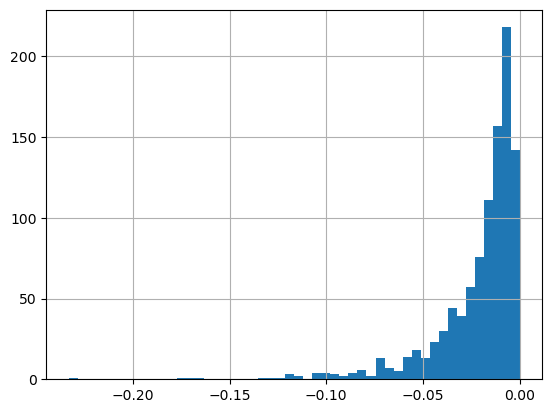

In [59]:
df_train["ret_distance_phigh_night_open"].hist(bins=50)

<AxesSubplot:>

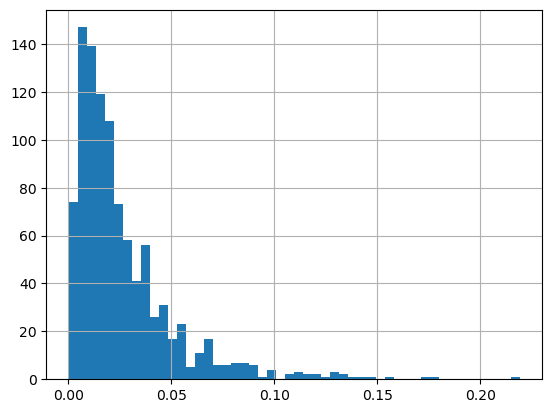

In [60]:
df_train["ret_distance_plow_night_open"].hist(bins=50)

## Model Training

- Train a logistic regression model
- Train a Random Forest Model (Tune parameters)
- Tain a XGBosst Model (Tune parameters)

In [92]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

train_dicts = df_train[numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test[numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

### Logistic regression

In [93]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [94]:
y_pred = model.predict_proba(X_val)[:, 1]
phigh = y_pred > 0.5
(y_val == phigh).mean()

0.7151515151515152

The prediction accuracy of the prediction in the validation set with logistic regression is 72%

### Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier

scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [96]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.821733
1,5,20,0.822435
2,5,30,0.827523
3,5,40,0.828495
4,5,50,0.828796


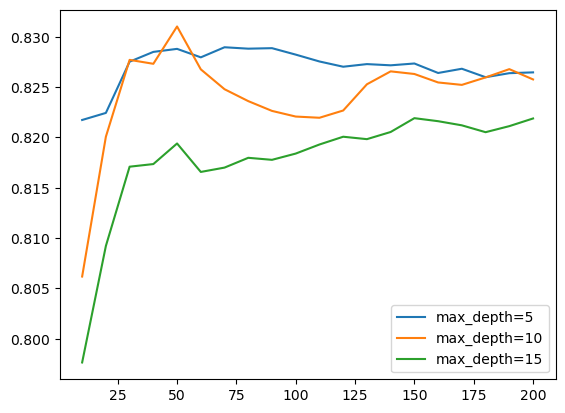

In [97]:
# Graphing 
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Best max_depth is 10

In [98]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=10,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

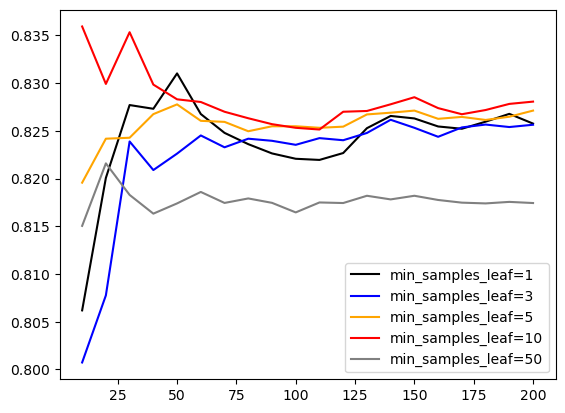

In [99]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

Best min_sample_leaf is 10 at 25 iterations

In [100]:
rf = RandomForestClassifier(n_estimators=25,
                            max_depth=10,
                            min_samples_leaf=10,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=25,
                       random_state=1)

In [101]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [102]:
roc_auc_score(y_val, y_pred)

0.8330728853628241

The roc auc score for the random forest model is 0.83

In [103]:
import xgboost as xgb
# The DMatrix allows for the XGBoost model to train faster as the DMatrix is optimised for the model. 
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

c:\Users\Pastor\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [104]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8314300597026885

The ROC AUC score with the default parameters in XGBoost is 0.83

In [105]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Let's optimize for eta

In [106]:
evals_result = {}
scores = {}
for eta in [0.001, 0.003, 0.005, 0.01,  0.1]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals_result=evals_result,
                    verbose_eval=100,
                    evals=watchlist)

    df_scores = pd.DataFrame([evals_result['train']['auc'], evals_result['val']['auc']]).T
    df_scores.columns = ['train', 'val_auc']
    df_scores['num_iter'] = df_scores.index
    scores[f'eta={eta}'] = df_scores

[0]	train-auc:0.90131	val-auc:0.81009
[100]	train-auc:0.90718	val-auc:0.79080
[199]	train-auc:0.91697	val-auc:0.80331
[0]	train-auc:0.90131	val-auc:0.81009
[100]	train-auc:0.92024	val-auc:0.80719
[199]	train-auc:0.92951	val-auc:0.81045
[0]	train-auc:0.90131	val-auc:0.81009
[100]	train-auc:0.92566	val-auc:0.81089
[199]	train-auc:0.93896	val-auc:0.80814
[0]	train-auc:0.90131	val-auc:0.81009
[100]	train-auc:0.93906	val-auc:0.80789
[199]	train-auc:0.95720	val-auc:0.82090
[0]	train-auc:0.90131	val-auc:0.81009
[100]	train-auc:0.99257	val-auc:0.82606
[199]	train-auc:0.99966	val-auc:0.82488


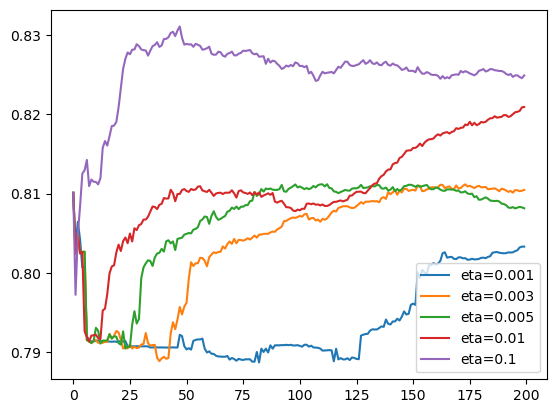

In [107]:
etas = ['eta=0.001','eta=0.003','eta=0.005','eta=0.01', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label = eta)
plt.legend()

Optimal eta=0.1

## Explor for max_depth

In [108]:
evals_result = {}
scores = {}
for depth in [1, 3, 5, 7]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': depth,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals_result=evals_result,
                    verbose_eval=100,
                    evals=watchlist)

    df_scores = pd.DataFrame([evals_result['train']['auc'], evals_result['val']['auc']]).T
    df_scores.columns = ['train', 'val_auc']
    df_scores['num_iter'] = df_scores.index
    scores[f'max_depth={depth}'] = df_scores

[0]	train-auc:0.70731	val-auc:0.69146
[100]	train-auc:0.87010	val-auc:0.83212
[199]	train-auc:0.88162	val-auc:0.83625
[0]	train-auc:0.83757	val-auc:0.77074
[100]	train-auc:0.93355	val-auc:0.83840
[199]	train-auc:0.96629	val-auc:0.82997
[0]	train-auc:0.88813	val-auc:0.80930
[100]	train-auc:0.98133	val-auc:0.82848
[199]	train-auc:0.99733	val-auc:0.82432
[0]	train-auc:0.91066	val-auc:0.80223
[100]	train-auc:0.99786	val-auc:0.83323
[199]	train-auc:0.99998	val-auc:0.82710


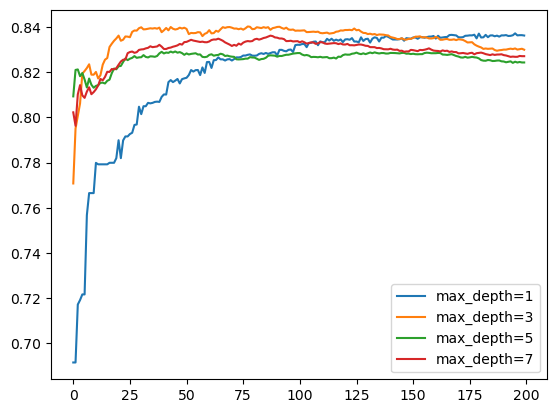

In [109]:
max_depth = ['max_depth=1','max_depth=3','max_depth=5', 'max_depth=7']

for d in max_depth:
    df_score = scores[d]
    plt.plot(df_score.num_iter, df_score.val_auc, label = d)
plt.legend()

Since max_depth 3 reach the maximun accuracy and in less number of iterations it would be choosen as the best max_depth for this dataset

## Optimize for min_child_weight

In [110]:
evals_result = {}
scores = {}
for child in [1, 3, 5, 7]:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': 3,
        'min_child_weight': child,
        
        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals_result=evals_result,
                    verbose_eval=False,
                    evals=watchlist)

    df_scores = pd.DataFrame([evals_result['train']['auc'], evals_result['val']['auc']]).T
    df_scores.columns = ['train', 'val_auc']
    df_scores['num_iter'] = df_scores.index
    scores[f'min_child_weight={child}'] = df_scores

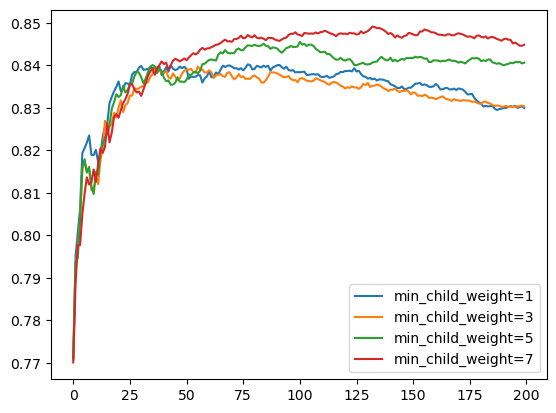

In [111]:
min_child_parameters= ['min_child_weight=1','min_child_weight=3','min_child_weight=5', 'min_child_weight=7']

for c in min_child_parameters:
    df_score = scores[c]
    plt.plot(df_score.num_iter, df_score.val_auc, label = c)
plt.legend()

The best min_child weight for this dataset is 7

The final model:

- min_child_weight = 7
- max_depth = 3
- eta (learning rate) = 0.1
- num_iter = 125

This final model reach up to 0.85 in the validation set

## Final model

In [113]:
df_train_full = df_train_full.reset_index(drop=True)
y_train_full = df_train_full[categorical[0]]

y_test = df_test[categorical[0]]

In [114]:
dicts_full_train = df_train_full[numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test[numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)


dfulltrain = xgb.DMatrix(X_full_train, label=y_train_full)
dtest = xgb.DMatrix(X_test)

In [115]:
xgb_params = {
    'eta':0.1,
    'max_depth': 3,
    'min_child_weight':7,

    'objective':'binary:logistic',
    'eval_metric':'auc',

    'nthread':8,
    'seed':1,
    'verbosity':1

}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=125)

In [116]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8575203518907564

In [ ]:
# this needs to run in the notebook
import bentoml
bentoml.xgboost.save_model("credit_risk_model", model,
                            custom_objects={
                                "dictVectorizer":dv
                            },
                            signatures={
                                "predict": {
                                    "batchable":True,
                                    "batch_dim":0,
                                }
                            })

We reach 0.8575 on the test set